# Assignment 6: Unsupervised Learning: Clustering

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In this assignment, you are going to investigate some of the functionality provided by Scikit-learn for performing unsupervised learning, specifically, clustering. We will use the World Happiness Report (WHR) data set and see to what extent we can group different countries together (into clusters) based solely on the features contained in the  data set.

You will complete the following tasks:

1. Build your DataFrame and define your ML problem
2. Prepare your data by cleaning the data and performing feature engineering
3. Perform KMeans Clustering and analyze the results
4. Perform Hierarchical Clustering and analyze the results


## Part 1. Build Your DataFrame and Define Your ML Problem

#### Load a Data Set and Save it as a Pandas DataFrame

Rather than working with all of the data, we will just examine the data from 2015-2017, which we will store in a DataFrame named ```df```.

In [2]:
filename = os.path.join(os.getcwd(), "data_clustering", "WHR2018Chapter2OnlineData.xls")

df = pd.read_excel(filename, sheet_name='Table2.1')

####  Inspect the Data

<b>Task</b>:  Inspect the data in DataFrame `df` by printing the number of rows and columns, the column names, and the first ten rows. You may perform any other techniques you'd like to inspect the data.

In [3]:
print(df.shape)
print(df.columns)
print(df.head(10))

(1562, 19)
Index(['country', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate)',
       'GINI index (World Bank estimate), average 2000-15',
       'gini of household income reported in Gallup, by wp5-year'],
      dtype='object')
       country  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008     3.723590            7.168690        0.450662   
1  Afghanistan  2009     4.401778            7.333790        0.552308   
2  Afghanistan  2010     4.758381            7.386629        0.539075   
3  Afghanistan  2011     3.831719            7.41501

#### Define the ML Problem 

Recall that Unsupervised Learning works with unlabeled data. Therefore, we do not have to select a label for our machine learning problem. 

Let's define our problem. We are interested in how similar different countries are to each other, based on their features.  Are there natural groupings or clusters of countries based upon similarity of their feature values?  This is the kind of question that the machine learning technique of clustering addresses.

#### Identify Features

We will use start by using the following columns as features.

In [4]:
features = ['country', 'year', 'Life Ladder', 
                   'Positive affect','Negative affect',
                   'Log GDP per capita', 'Social support',
                   'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 
                   'Generosity', 'Perceptions of corruption']

<b>Task</b>: Modify DataFrame `df` to only contain the feature columns listed above.

In [5]:
df = df[features]

In [6]:
df.columns

Index(['country', 'year', 'Life Ladder', 'Positive affect', 'Negative affect',
       'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption'],
      dtype='object')

<b>Task</b>:  Let's change the more complex feature names to ones that are simpler.  Use the dictionary containing old names and new names below, along with the Pandas `rename()` method, to change the names of the columns. For more information on the `rename()` method, consult the online [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html).

In [7]:
new_names_dict = {'Life Ladder': 'Happiness', 
            'Log GDP per capita': 'LogGDP', 
            'Social support': 'Support', 
            'Healthy life expectancy at birth': 'Life', 
            'Freedom to make life choices': 'Freedom', 
            'Perceptions of corruption': 'Corruption', 
            'Positive affect': 'Positive', 
            'Negative affect': 'Negative'}

df = df.rename(columns=new_names_dict)

In [8]:
df.columns

Index(['country', 'year', 'Happiness', 'Positive', 'Negative', 'LogGDP',
       'Support', 'Life', 'Freedom', 'Generosity', 'Corruption'],
      dtype='object')

There's one more piece of information that we'd like to include in our feature list. This is the region to which each country belongs, such as "Central and Eastern Europe," and "Latin America and Carribean." The WHR contains this information. Let's extract this info from the `SupportingFactors` worksheet:


In [9]:
df_regions = pd.read_excel(filename, sheet_name='SupportingFactors')

In [10]:
df_regions.columns

Index(['country', 'Region indicator', 'Life ladder, 2015-2017',
       'Standard error, life ladder, 2015-2017',
       'Log of GDP per person, 2015-2017', 'GDP per person, 2015-2017',
       'Healthy life expectancy, 2015-2017', 'Social support, 2015-2017',
       'Standard error, social support, 2015-2017',
       'Freedom to make life choices, 2015-2017',
       'Standard error, freedom to make life choices, 2015-2017',
       'Generosity, 2015-2017, without adjustment for GDP per person',
       'Standard error, generosity, 2015-2017',
       'Perceptions of corruption, 2015-2017',
       'Standard error, perceptions of corruption, 2015-2017'],
      dtype='object')

<b>Task</b>: Modify DataFrame `df_regions` to only contain the feature columns `country` and `Region indicator`.

In [11]:
df_regions = df_regions[['country', 'Region indicator']]

Let's inspect DataFrame `df_regions`.

In [12]:
df_regions.head(15)

,country,Region indicator
0,Afghanistan,South Asia
1,Albania,Central and Eastern Europe
2,Algeria,Middle East and North Africa
3,Angola,Sub-Saharan Africa
4,Argentina,Latin America and Caribbean
5,Armenia,Commonwealth of Independent States
6,Australia,North America and ANZ
7,Austria,Western Europe
8,Azerbaijan,Commonwealth of Independent States
9,Bahrain,Middle East and North Africa


<b>Task</b>:  Change the name of the `Region indicator` column to  `Region`.

In [13]:
df_regions = df_regions.rename(columns={'Region indicator': 'Region'})

In [14]:
df_regions.columns

Index(['country', 'Region'], dtype='object')

<b>Task:</b> Merge DataFrame `df_regions` with DataFrame `df` based on the common column `country`. Use the Pandas `merge()` method. For more information on `merge()`, consult the online [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).

In [15]:
df = pd.merge(df, df_regions, on='country')

<b>Task:</b> Print a list of the features.

In [16]:
df.columns.tolist()

['country',
 'year',
 'Happiness',
 'Positive',
 'Negative',
 'LogGDP',
 'Support',
 'Life',
 'Freedom',
 'Generosity',
 'Corruption',
 'Region']

Finally, let's set the index of DataFrame `df` to be the country name:

In [17]:
df.set_index('country', inplace=True)

## Part 2. Prepare Your Data

Now that we have identified our features, let's perform data preparation techniques to prepare our data for modeling.

You will first clean your data by handling missing values and will then perform feature engineering by performing data aggregation and scaling.

#### Handle Missing Data

**Task**: Check if DataFrame `df` contains missing values, and sum up the resulting values by columns. Print the results.

In [18]:
missing_values = df.isnull().sum()
missing_values

year           0
Happiness      0
Positive      16
Negative      11
LogGDP        23
Support       11
Life           5
Freedom       29
Generosity    75
Corruption    88
Region         0
dtype: int64

<b>Task:</b> Remove all examples (rows) that contains missing values.

In [19]:
df = df.dropna()

<b>Task</b>: Inspect DataFrame `df` to see the if it still has missing values by once again summing up the missing values by columns.

In [20]:
df.isnull().sum()

year          0
Happiness     0
Positive      0
Negative      0
LogGDP        0
Support       0
Life          0
Freedom       0
Generosity    0
Corruption    0
Region        0
dtype: int64

#### Perform Data Aggregation

Data aggregation is also called the summarization of data. We can perform data aggregation by performing aggregate functions on a group of data to create new data. For example, we can merge examples (rows) in a DataFrame by replacing these examples with one example that contains the mean or sum of the different feature values in the group.

Let's inspect our current data.

In [21]:
df.head(15)

,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,Region
country,,,,,,,,,,,
Afghanistan,2008,3.723590,0.517637,0.258195,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,South Asia
Afghanistan,2009,4.401778,0.583926,0.237092,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,South Asia
Afghanistan,2010,4.758381,0.618265,0.275324,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,South Asia
Afghanistan,2011,3.831719,0.611387,0.267175,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,South Asia
Afghanistan,2012,3.782938,0.710385,0.267919,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,South Asia
Afghanistan,2013,3.572100,0.620585,0.273328,7.503376,0.483552,51.042980,0.577955,0.074735,0.823204,South Asia
Afghanistan,2014,3.130896,0.531691,0.374861,7.484583,0.525568,51.370525,0.508514,0.118579,0.871242,South Asia
Afghanistan,2015,3.982855,0.553553,0.339276,7.466215,0.528597,51.693527,0.388928,0.094686,0.880638,South Asia
Afghanistan,2016,4.220169,0.564953,0.348332,7.461401,0.559072,52.016529,0.522566,0.057072,0.793246,South Asia


Notice that we have multiple examples (rows) per country, each containing information for different years. We can group examples together by country and merge them so that we can have one example per country. Let's do so by computing the mean values of all the features for each country, averaging over all years in the data set. Our resulting DataFrame `df` will then contain one example per country. 

In [22]:
df = df.groupby(['country', 'Region']).mean().reset_index()

Let's inspect our new data.

In [23]:
df.head(15)

,country,Region,year,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
0,Afghanistan,South Asia,2012.500000,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794
1,Albania,Central and Eastern Europe,2012.400000,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691
2,Algeria,Middle East and North Africa,2013.333333,5.390234,0.598735,0.257774,9.499098,0.818795,64.989372,0.517632,-0.200306,0.675957
3,Angola,Sub-Saharan Africa,2012.500000,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018
4,Argentina,Latin America and Caribbean,2011.500000,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038
5,Armenia,Commonwealth of Independent States,2011.500000,4.386683,0.543565,0.432749,8.906013,0.705386,64.165676,0.520092,-0.192519,0.882539
6,Australia,North America and ANZ,2012.300000,7.305930,0.806852,0.215710,10.661784,0.947422,72.171539,0.922925,0.293790,0.409955
7,Austria,Western Europe,2012.200000,7.234409,0.795045,0.167963,10.696035,0.928381,71.178088,0.906110,0.148707,0.596848
8,Azerbaijan,Commonwealth of Independent States,2011.500000,4.902705,0.565277,0.239572,9.624816,0.760092,62.152107,0.636899,-0.183966,0.729846
9,Bahrain,Middle East and North Africa,2010.000000,5.487123,0.663947,0.452760,10.608648,0.896375,65.275709,0.875935,-0.019195,0.601082


<b>Task:</b> We no longer need the `year` column. Remove the `year` column from DataFrame `df`.

In [24]:
df = df.drop(columns=['year'])

In [25]:
df.columns

Index(['country', 'Region', 'Happiness', 'Positive', 'Negative', 'LogGDP',
       'Support', 'Life', 'Freedom', 'Generosity', 'Corruption'],
      dtype='object')

#### Scale the Data

Let's scale the numerical data to normalize each column to have zero mean and unit standard deviation.

We will use Scikit-learn's `StandardScaler` to accomplish this. Use the online [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) as a reference for how to use `StandardScaler`.

First, let's import `StandardScaler`.

In [26]:
from sklearn.preprocessing import StandardScaler

<b>Task:</b> In the code cell below, do the following:

1. Create a `StandardScaler` object by calling `StandardScaler()`. Save the result to variable `scaler`.
2. Extract numerical features from DataFrame `df` and save the feature columns to DataFrame `df_to_scale`.
3. Call the `scaler.fit_transform()` method to fit the scaler to `data_to_scale` and transform the data. Save the result to `transformed_data`.
4. Call `pd.DataFrame()` to create a new DataFrame. Name the DataFrame `df_scaled`. Pass `transformed_data` as an argument. Specify the following parameters:
    * `columns`: the column parameter should be given the column names from `df_to_scale` 
    * `index`: the index parameter should be given the value of `df_to_scale.index`.

In [27]:
# 1. Create a StandardScaler object and save the result to variable scaler.
scaler = StandardScaler()

# 2. Extract numerical features from DataFrame df and save it to DataFrame df_to_scale.
df_to_scale = df.select_dtypes(include=['number'])


# 3. Call the scaler.fit_transform() method to fit the scaler to data_to_scale
# and tranform the data. Save the result to transformed_data.
transformed_data = scaler.fit_transform(df_to_scale)


#4. Create new DataFrame df_scaled
df_scaled = pd.DataFrame(transformed_data, columns=df_to_scale.columns, index=df_to_scale.index)


# Inspect df_scaled
df_scaled

,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption
0,-1.452072,-1.257848,0.496224,-1.442164,-2.428763,-1.334205,-1.358133,0.732571,0.449524
1,-0.364486,-0.630475,0.524190,0.049492,-0.686872,0.772824,-0.744811,-0.714285,0.629916
2,0.004836,-1.076383,-0.120463,0.255229,0.121202,0.400444,-1.563904,-1.331282,-0.377585
3,-0.887491,-0.928025,1.203360,-0.385691,-0.562017,-1.224921,-2.029402,-0.538942,0.670092
4,0.939446,1.384782,0.098002,0.522117,0.859056,0.618004,0.213481,-1.034962,0.544082
...,...,...,...,...,...,...,...,...,...
147,0.878179,1.210719,-0.679733,0.431834,0.993976,0.300698,-0.433547,-1.278057,0.240147
148,-0.021940,-0.908530,-0.884423,-0.607008,0.142679,0.430435,1.096105,0.053442,0.200615
149,-1.256452,-1.576371,0.463639,-0.778749,-0.969679,-0.946380,-0.657596,-0.987834,0.484862
150,-0.643620,0.183922,0.131736,-0.890554,-0.494271,-1.480713,0.184358,-0.091720,0.477526


In [30]:
np.std(df['Happiness'])

1.0869733683068787

## Part 3. Visualize the Data

The `df_scaled` DataFrame contains, for each country listed, a group of nine numerical features.  The `Region` feature column from ```df``` has been removed because that is categorical rather than numerical.  Since we have scaled the data to have zero mean, any numerical entry that is greater than zero indicates a value above average, and any entry that is less than zero indicates a value below average.  Therefore, we can think of each country as being "defined" by this group of nine features.

We are interested in how similar different countries are to each other, based on their feature values.  

To begin, let's have a visual look at the data, which consists of 152 rows x 9 columns.  The code cell below uses the seaborn `heatmap()` function to make a heatmap of `df_scaled`.

The default rendering of the heatmap is not ideal, being somewhat short and squat when the dataset is much longer.  To get around this, we first create a figure with a size that is better suited to this plot, and then make the call to `heatmap()`.  

Since we have requested a large figure size, it is possible that the figure might be embedded in a scrollable sub-window rather than rendered in its entirety in the notebook as is usually the case. If you'd like to be able to expand the sub-window and get the figure embedded fully within the notebook, you can click on the panel to the left of the figure (under the Out[] indicator, i.e., to the left but still within the notebook). If you decide you want to convert it back again to a scrollable sub-window, you can click in that left panel again.

<AxesSubplot: >

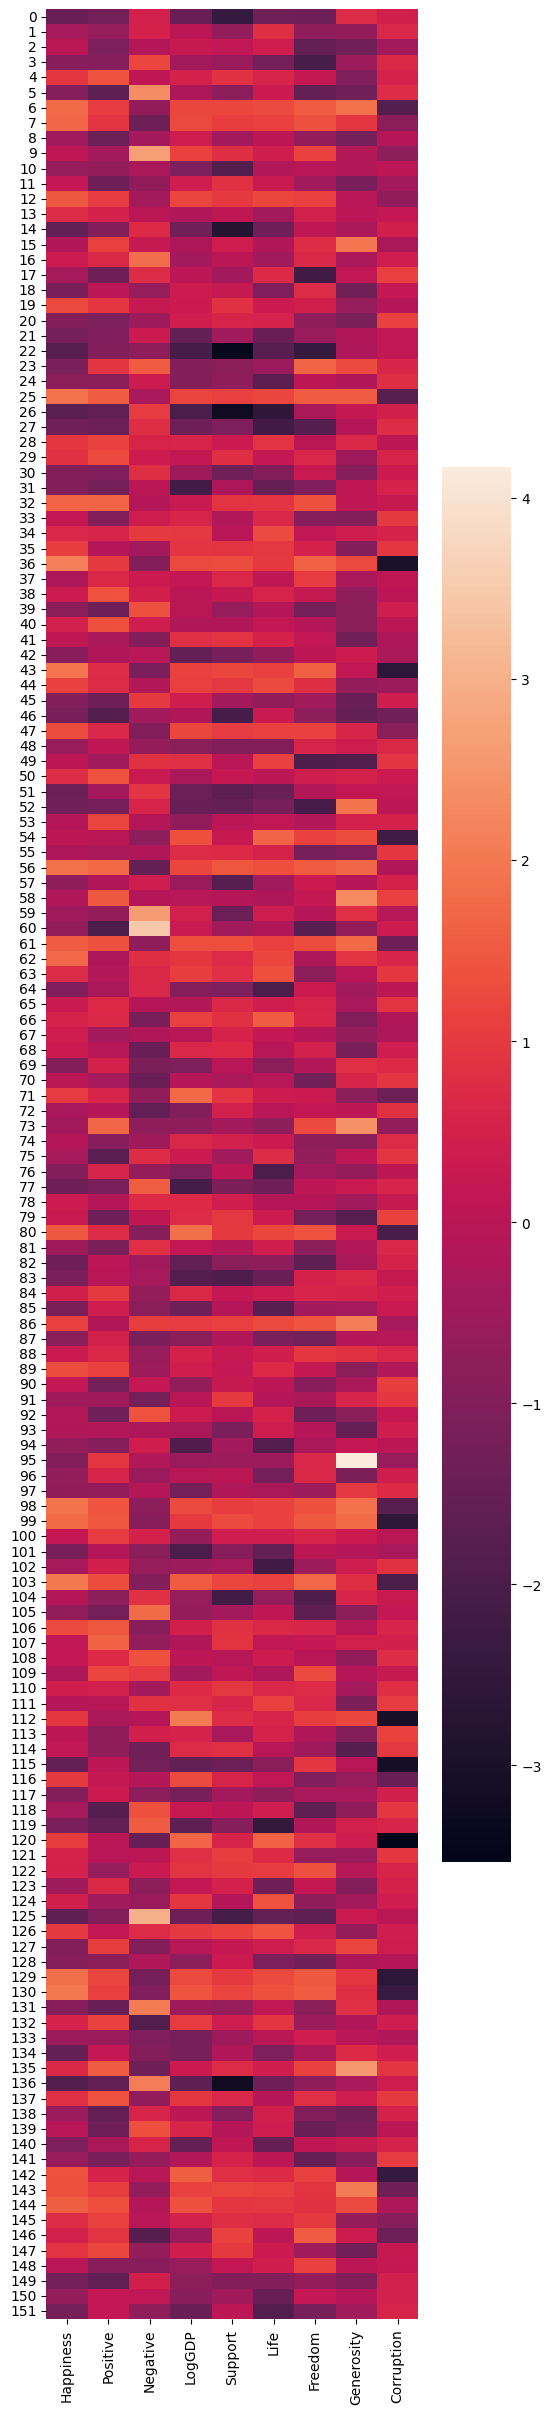

In [28]:
plt.figure(figsize = (6,30))
sns.heatmap(df_scaled)

## Part 4. Perform KMeans Clustering and Analyze the Results

The countries in the heatmap you have just created are ordered alphabetically, leading to what looks like a random pattern of feature values as you scan down the heatmap.  The point of clustering is to pull out subgroups (clusters) that share similar feature profiles.

The first clustering algorithm we will examine is KMeans (sometimes written as k-means or K-means), which is described in more detail in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means). 

With KMeans, one specifies in advance how many clusters one would like to group the data into, and this value is the number $K$, hence the name of the method.  Sometimes one needs to experiment with different values of $K$ to see what best reflects the nature of the data. KMeans works by finding a set of "centroid" points at the center of each cluster, so that every data point (example) within a cluster is closer to the center of its own cluster than to the centroid of a different cluster.

In a hypothetical dataset with $N$ examples, a "perfect but meaningless" clustering of the data would involve making as many clusters as there are examples, that is, setting $K = N$.  In such a scenario, every example (e.g., every country in our dataset) would be in its own cluster, perfectly identical to itself, but meaningless in terms of revealing structure and patterns in the data.  In the opposite limit, $K = 1$, all the examples would be in the same cluster, which leaves us no better than where we started.  The point of clustering is to find a number of clusters $K$ (somewhere between $1$ and $N$) that captures substructure within the data.

In the case of our WHR data, a useful guess for $K$ might reflect the number of different regions that are contained in  DataFrame `df`. In this exercise, we want to cluster countries based on the WHR features, and might be interested in how well the clustering reflects the region data.  Thus, a useful place to start here is to set $K$ to be the number of unique regions contained in DataFrame `df`.

### Step 1: Determine the Number of Clusters $K$
Let's first figure out how many clusters we want to find.

<b>Task:</b>

* Find the number of unique values contained in the `Region` feature in DataFrame `df`. Save the results to  variable`K`.
* Print the value of `K`.

In [29]:
K = df['Region'].nunique()
K

10

### Step 2: Apply KMeans Clustering to the Data

Having identified the number of clusters we want to look for, let's continue with Kmeans. 

First let's import Scikit-learn `KMeans` class. For more information, consult ```KMeans``` Scikit-learn online [dcocumentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [30]:
from sklearn.cluster import KMeans

<b>Task:</b> In the code cell below:

1. Create a ```KMeans```model object, specifying the parameter `n_clusters` to contain the number of clusters $K$, and assign the results to the variable `kcluster_model`. 

2. Fit the model to `df_scaled`.

In [40]:
kcluster_model = KMeans(n_clusters=K)
kcluster_model.fit(df_scaled)

KMeans(n_clusters=10)

The output from the code cell above, if entered and run correctly, should note some further information about the `KMeans` clusterer that you have created and fit to the data.  There are various other options that can in principle be specified in constructing the object; the only option we specified above was ```n_clusters```, and used the default values of everything else.  

You will notice an entry for ```n_init=10```.  This refers to the fact that the Kmeans algorithm starts from a initial guess for the centroid locations, and runs the algorithm repeatedly with different starting guesses (`n_init` times), choosing the best clustering from the group.

### Step 3. Label Each Example with the Cluster It Belongs To

Once the `KMeans` clusterer has fit the data, it contains various data attributes that we can query. One of these attributes is the ```labels_``` object, which is an array of integers that assigns a cluster label to each example in the dataset.  For our WHR data, therefore, the ```labels_``` object describes, in the same order in which the data appears in our ```df_scaled``` DataFrame, which cluster each country belongs to.

The code cell below prints the value of ```kcluster.labels_```. Run the cell and examine the output.

In [41]:
print(kcluster_model.labels_)

[5 4 4 7 8 7 0 6 4 2 1 4 6 2 5 9 2 7 3 8 4 1 5 9 1 0 5 5 2 2 1 1 6 4 2 8 0
 2 2 7 2 8 1 0 8 7 1 6 3 4 2 1 5 2 0 4 6 1 9 7 7 0 6 4 1 2 8 4 8 3 4 8 3 9
 4 7 3 1 2 4 0 7 3 1 2 3 6 3 2 8 4 4 7 4 1 9 3 3 0 0 2 3 3 0 5 7 8 2 2 2 8
 8 0 4 4 3 8 3 7 1 0 4 8 3 4 5 8 9 3 0 0 7 8 3 3 9 5 6 7 7 1 4 0 0 6 8 6 8
 2 1 3 3]


The actual numbers associated with the cluster labels are meaningless, and will change each time you run the clustering algorithm.  (By this we mean that we could permute the labels of all the clusters, and the underlying clustering of the data would remain unchanged.)  What is meaningful, however, is which countries *share* the same cluster label, since that means they are assigned to the same cluster (regardless of what cluster label number that is).  Since the cluster labels printed above contain no information about the countries they correspond to, it is useful to combine the cluster labels with the DataFrames that they originated from.  We'll do that by creating a copy of both the ```df``` and ```df_scaled``` DataFrames, and adding information about the cluster labels.

<b>Task:</b> In the code cell below:

1. Make a copy of DataFrame `df` using its `copy()` method. Assign the result to a new DataFrame named `df_clustered`.
2.  Add a new column named `klabel` to `df_clustered`. This column should contain the values in `kcluster.labels_` 
3. Make a copy of DataFrame `df_scaled` and assign the result to a new DataFrame named `df_scaled_clustered`.
4. Add a new column named `klabel` to `df_scaled_clustered`. This column should contain the values in `kcluster.labels_` 



In [42]:
df_clustered = df.copy()
df_clustered['klabel'] = kcluster_model.labels_
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['klabel'] = kcluster_model.labels_

Execute the code cell below and examine the new ```df_clustered``` DataFrame.  You should see the `klabel` column now &mdash; any two countries with the same label have been assigned to the same cluster.

In [43]:
df_clustered

,country,Region,Happiness,Positive,Negative,LogGDP,Support,Life,Freedom,Generosity,Corruption,klabel
0,Afghanistan,South Asia,3.806614,0.580873,0.301283,7.419697,0.517146,50.838271,0.544895,0.118428,0.826794,5
1,Albania,Central and Eastern Europe,4.988791,0.642628,0.303256,9.247059,0.723204,68.027213,0.626155,-0.105019,0.859691,4
2,Algeria,Middle East and North Africa,5.390234,0.598735,0.257774,9.499098,0.818795,64.989372,0.517632,-0.200306,0.675957,4
3,Angola,Sub-Saharan Africa,4.420299,0.613339,0.351173,8.713935,0.737973,51.729801,0.455957,-0.077940,0.867018,7
4,Argentina,Latin America and Caribbean,6.406131,0.840998,0.273187,9.826051,0.906080,66.764205,0.753122,-0.154544,0.844038,8
...,...,...,...,...,...,...,...,...,...,...,...,...
147,Venezuela,Latin America and Caribbean,6.339535,0.823864,0.218316,9.715448,0.922040,64.175655,0.667396,-0.192087,0.788611,8
148,Vietnam,Southeast Asia,5.361130,0.615258,0.203875,8.442810,0.821336,65.234033,0.870063,0.013546,0.781401,2
149,Yemen,Middle East and North Africa,4.019248,0.549520,0.298984,8.232418,0.689749,54.002107,0.637711,-0.147265,0.833238,1
150,Zambia,Sub-Saharan Africa,4.685380,0.722792,0.275567,8.095450,0.745987,49.643073,0.749263,-0.008872,0.831900,3


### Step 4. Analyze the Results

Recall that each cluster is approximately defined by its centroid, which we can think of as a typical or average feature profile for that cluster.  Our examples actually live in a 9-dimensional space (9 numerical features), so it's a little hard to visualize the data.  But if we want to see what each of the clusters approximately "looks like," we can just plot the coordinates of the cluster centroids, which are stored in the attribute ```kcluster.cluster_centers_```.

Execute the code cell below to make a plot of the cluster centers and their associated label numbers.  Note that the cluster centers are all distinct from one another, although clusters are somewhat closer to each other.  This might be indicative of the fact that $K=10$ might be too many clusters to properly represent this dataset; if $K$ were reduced, some of the nearby clusters would probably collapse into a larger metacluster reflecting their approximately common profile.  We'll just examine the $K=10$ case in this exercise, but if you're interested in investigating further on your own, you could try some other values of $K$ to see how the results change.

Feel free to modify the code if you want to tweak the plot, or to understand what each of the commands there is doing.

In [44]:
numerical_features = ['Happiness', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption', 'Positive', 'Negative']


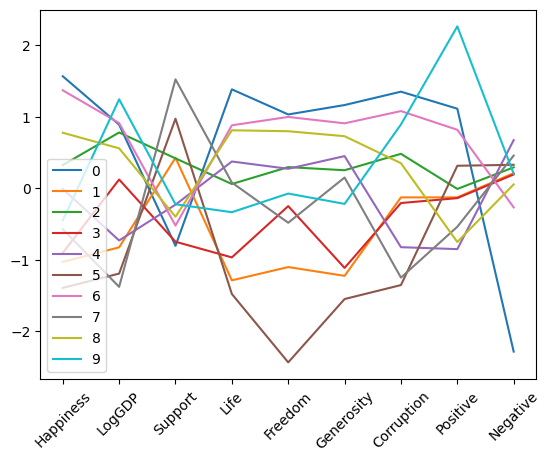

In [45]:
for i in range(10):
    plt.plot(kcluster_model.cluster_centers_[i], label=i)
plt.xticks(range(9), numerical_features, rotation=45)
plt.legend()

In the plot above, each line represents the centroid of one cluster (for clusters labeled 0 through 9).  For each cluster, there is a group of countries whose features lie near to these centroids.

First examine, and then execute, the code cell below.  

The code cell below defines a function called ```plot_cluster_and_centroid```, which takes as input an integer cluster label, and plots all country profiles within the cluster (in different colors) along with the centroid profile (plotted with a black dashed line and black point markers).

After the function definition, the function is called to produce a plot for cluster label 0.

<b>Task:</b> Modify the code cell below to plot all Clusters. Once you've examined the plot for cluster 0, modify the cluster label being passed to the function in order to view each of the other 9 clusters that have been produced (10 clusters in all, since we set $K = 10$).  In other words, modify the input to the function one at a time, and re-execute the code cell, or &mdash; if you prefer &mdash; open up additional code cells below to plot each of the clusters in turn. At present, the plot turns off the legend indicating the names of the countries in each cluster (```legend=False```), since the legend clutters the figure for large clusters and is difficult to reposition.  But if you're curious, try turning the legend back on to see the contents of each cluster.

Take some time to examine these plots to understand what they are conveying.  Some clusters represents countries that might have greater `Happiness` and lower `Corruption`, for example, whereas others might represent different combinations of attributes.

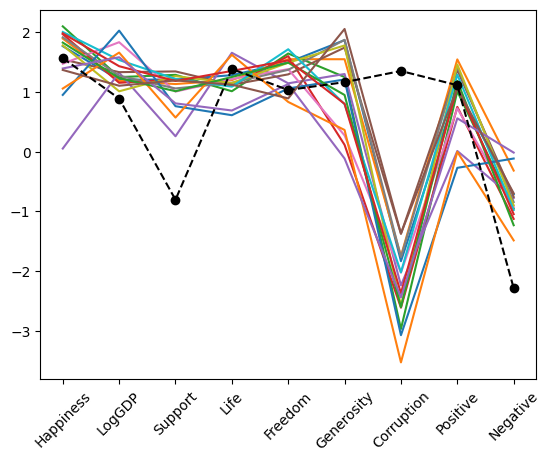

In [46]:
def plot_cluster_and_centroid(label):
    df_scaled_clustered[df_scaled_clustered.klabel==label][numerical_features].T.plot(legend=False)
    plt.plot(kcluster_model.cluster_centers_[label], 'ko--')
    plt.xticks(range(9), numerical_features, rotation=45)

# Call plot_cluster_and_centroid() multiple times with each cluster label (0-9) as an argument 
# and analyze the resulting plots
plot_cluster_and_centroid(0)

We might be interested in how the results produced by KMeans clustering relate to the region information that is stored in DataFrame ```df_clustered```.  As we discussed above, the cluster labels themselves are meaningless, but we can easily examine how each cluster label (`klabel`) aligns with different world regions.  For example, we might want to know how many countries from each region are associated with cluster number 0, cluster number 1, etc.

The code cell below contains an expression to group the data in ```df_clustered``` by both `klabel` and `Region`, and compute the size of each (`klabel`, `Region`) pair. It is done in one line using the ```groupby()``` method, along with the ```size()``` method that is applied to each group produced by the `groupby` operation.  An operation of this sort will produce a new DataFrame with a two-level MultiIndex (i.e., each row described by its (`klabel`, `Region`) pair), with the corresponding column indicating how many countries are associated with that pair.

In [47]:
df_clustered.groupby(['klabel', 'Region']).size()

klabel  Region                            
0       East Asia                              1
        Middle East and North Africa           2
        North America and ANZ                  3
        Southeast Asia                         1
        Western Europe                         9
1       Commonwealth of Independent States     1
        Middle East and North Africa           1
        South Asia                             2
        Sub-Saharan Africa                    12
2       Latin America and Caribbean           13
        Middle East and North Africa           2
        Southeast Asia                         3
        Sub-Saharan Africa                     1
        Western Europe                         1
3       Commonwealth of Independent States     2
        South Asia                             1
        Sub-Saharan Africa                    17
4       Central and Eastern Europe             9
        Commonwealth of Independent States     5
        East Asia         

## Part 4. Perform Hierarchical Clustering and Analyze the Results


The Kmeans algorithm is just one of many clustering algorithms supported by Scikit-learn.  A colorful overview of different clustering methods is provided in the Scikit-learn online [documentation](https://scikit-learn.org/stable/modules/clustering.html).

Another widely used clustering method is known as [Hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), some variants of which are known as agglomerative clustering.  This method takes a slightly more nuanced approach to the process of clustering.  Whereas KMeans clustering specifies a fixed number of clusters to group data into, hierarchical clustering develops a "hierarchy" of clustering relationships where data points are grouped more closely together if they are more similar to each other.  It's somewhat like the way that ancestry works.  If someone were to ask you how many people you are related to, you might reply that it depends on how far back they want to go in time to define "relatedness." Presumably we are all related to each other (however remotely) if we go back far enough in time to a common evolutionary ancestor, but that fact might not be so useful in defining "relatedness" or "clusters" of people.  Nonetheless, hierarchical clustering does provide insight into these hierarchical relationships among clusters, and lends itself to useful visualization techniques that reveal those relationships.

Scikit-learn provides objects and methods for `AgglomerativeClustering` that operate similarly to the way that the KMeans object worked above, by creating a clustering object and then fitting it to the dataset of interest.  If you're interested, you can investigate this further by following along with the Scikit-learn documentation.  Unfortunately, Scikit-learn does not provide great support for plotting the results of hierarchical clustering, generally referred to as dendograms.  There is some code showing a [simple example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html).

Instead, we can work with `seaborn`, which provides a useful function called `clustermap()` that does two things: it performs hierarchical clustering and then displays the results.  The `clustermap()` function is described in the seaborn online [documentation](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap).  The function  uses a version of the clustering algorithm that is included as part of [scipy](http://scipy.org), a Python package that provides a wealth of useful tools for scientific computing.

The code cell below contains a call to `sns.clustermap()` to operate on DataFrame `df_scaled`, providing the following additional options:

* ```method = 'average'```
* ```metric = 'euclidean'```
* ```figsize = (15,40)```

Note that the data is clustered inc`df_scaled`.  You wouldn't want to cluster the data in the augmented DataFrame that you created above (```df_scaled_clustered```), because that contains additional information about the KMeans cluster labels that you don't want to include here.

The code constructs and displays a figure that looks a bit like the heatmap that we created earlier in this exercise, but with some differences.  As was discussed above, if the figure is in a sub-window that you'd like to expand, you can click on the panel to the left of the figure to do so.

After you have examined the figure, proceed to the material below the figure to read further about what is plotted.

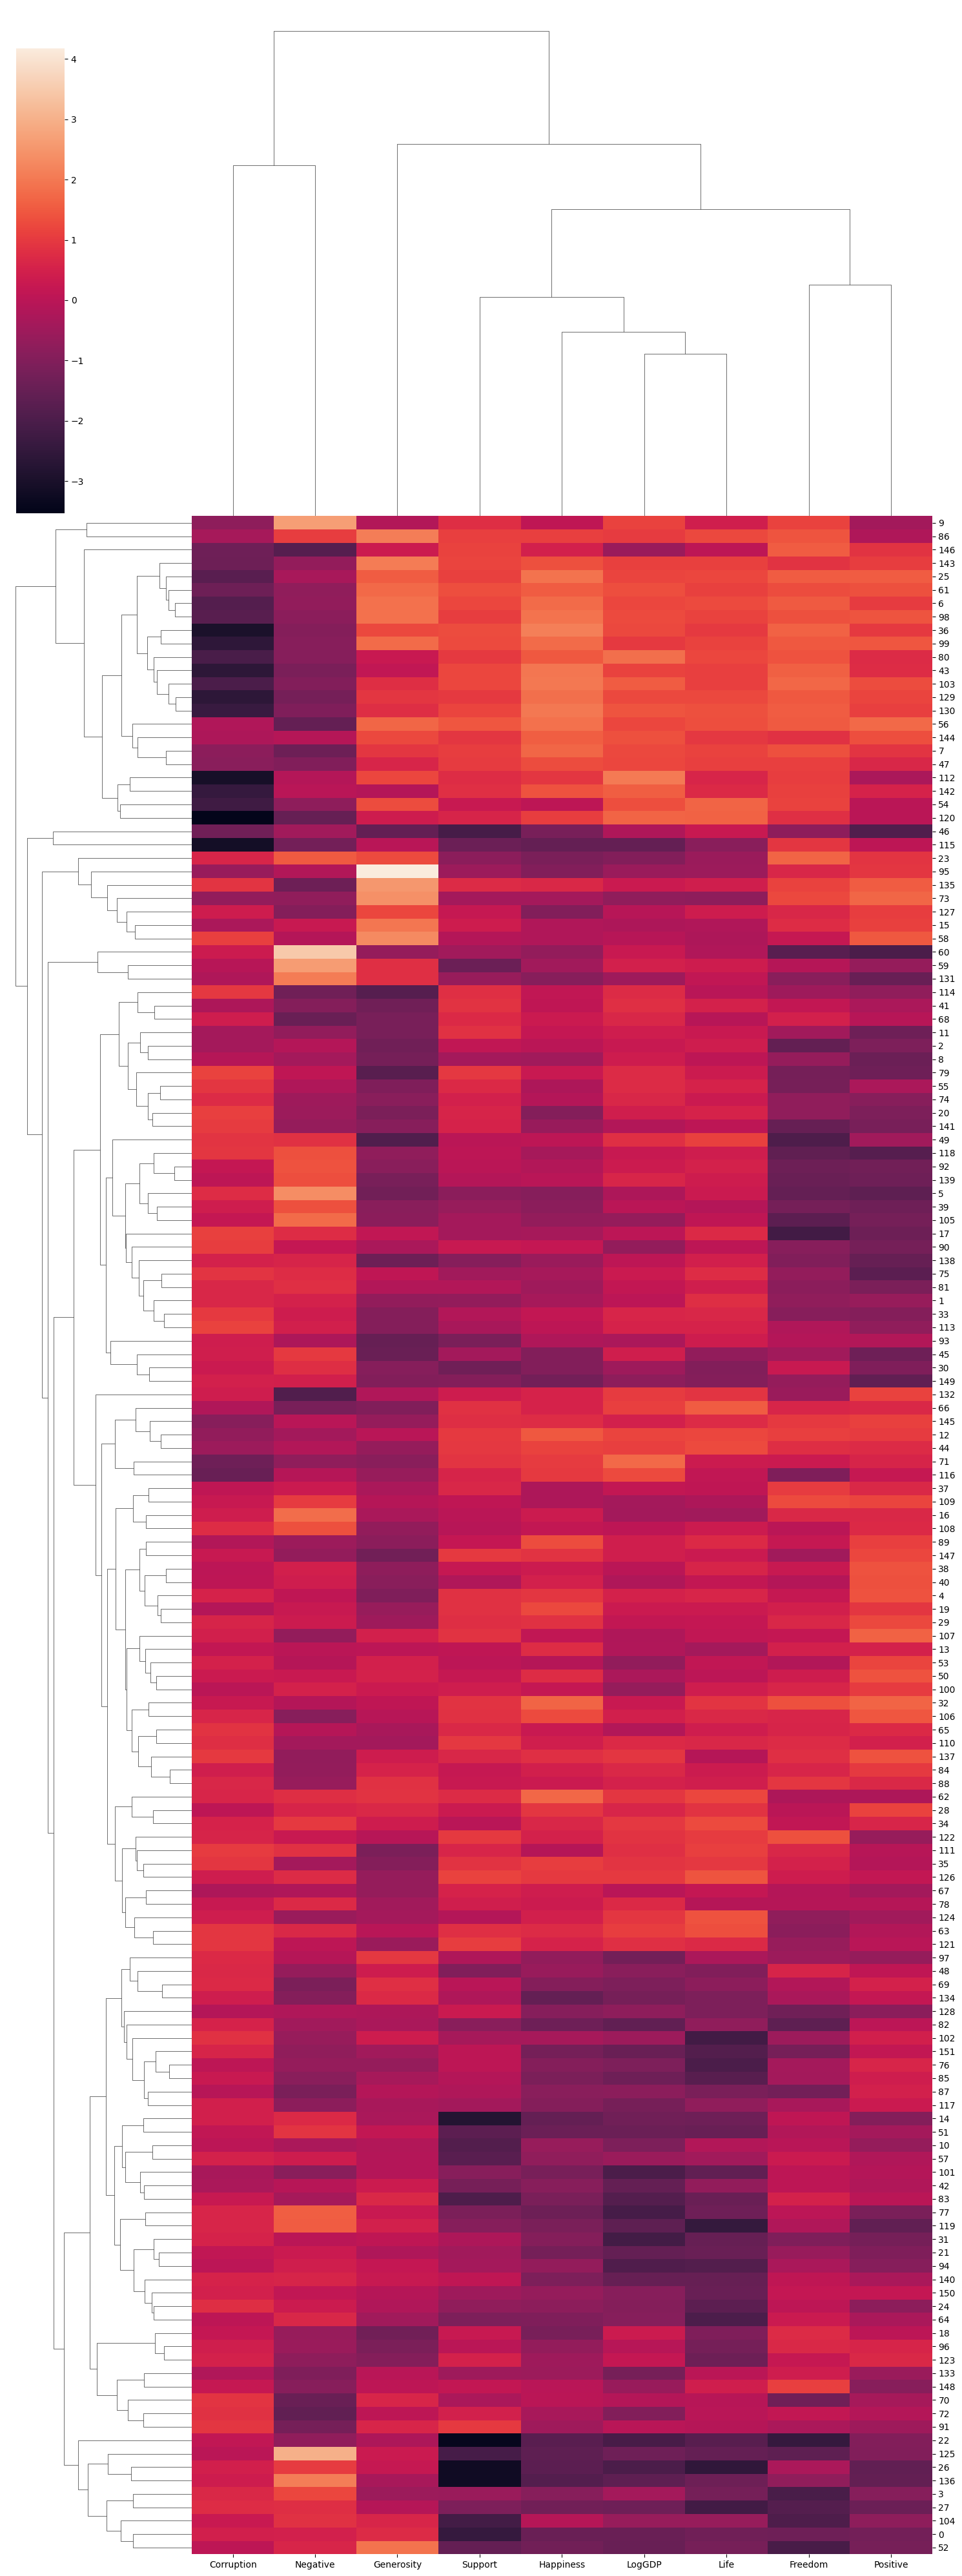

In [48]:
numerical_features = ['Happiness', 'LogGDP', 'Support', 'Life', 'Freedom', 'Generosity', 'Corruption', 'Positive', 'Negative']

sns.clustermap(df_scaled[numerical_features], method='average', metric='euclidean', figsize=(15,40))

There are several things you should notice about the plot produced by the clustermap.  First, whereas our original heatmap ordered the countries alphabetically, with a more or less random pattern of indicator values as a result, this clustermap has reordered the rows to reflect the clustering.

You should also notice a tree-like structure running along the left-hand side of the heatmap.  This tree, also known as a dendogram, is what is providing information about the clustering.  It is a tree, because it starts from a broad trunk at the far left of the dendogram down to finer and finer sub-branches and finally down to individual "leaves" that represent individual countries.  The clustering algorithm works from the bottom up: It finds several pairs of countries that are highly similar within each pair (smallest euclidean distance between them, in this version of the analysis), and then finds other countries that are similar to each pair.  Thus the algorithm grows clusters by agglomerating onto groupings that have already been identified.  The similarity between two countries in the tree is reflected by how far you need to go "up" the tree from one country and then back "down" to the other one.  If you go far enough up the tree, all countries are similar enough to each other to be grouped in one big cluster, similar to how all people are related to one another if we go back far enough in time.  Two countries that are near each other vertically in the reordered heatmap tend to be more similar to each other, but that is not strictly the case.  You should notice that at particular parts of the dendogram different branches end up getting placed nearby each other in this 2D representation, but their distance from each other up and back down the tree could be very far.

There are some other things to notice in this plot.  

First, despite the fact that nearby ordering in the heatmap does not always reflect close similarity in the tree, you should be able to discern some clustering visually in the reordered heatmap, that is, groups of countries with similar WHR feature values.  If you see a group of countries with similar feature values (similar patterns of colors in the heatmap), you should be able to identify the sub-tree on the left that group is associated with.

Second, you should notice that the columns of the dataset have also been clustered, with their own dendogram running along the top.  This is indicative of the fact that some groups of features are more closely associated among themselves, such as `LogGDP` and `Life` (life expectancy) which are clustered more closely together.  Clustering along both axes of a dataset is known as "biclustering", and is turned on by default in ```clustermap()```.  If you want to cluster only along one axis, you could modify either the `row_cluster` or `col_cluster` options to the function.

Finally, we have chosen just one set of criteria to carry out this clustering (```method='average'``` and ```metric='euclidean'```).  In order to identify groups of similar items in a dataset, we need to specify mathematically what we mean by "similar."  In this case, we have defined the similarity of two examples based on their euclidean distance from each other (such that two identical items would be separated by zero distance).  But we could have chosen some other criterion instead, such as the correlation between two examples.  In addition, in hierarchical clustering, one needs to specify not only how similar two *data points* are, but also to specify how similar two *clusters* are (since it is building up clusters of clusters).  This is what the `method` parameter is about (or more specifically, what is called the "linkage method").  The similarity between two clusters might be based on how similar their two closest items are, or their two most distant items, or the average distance between all pairs of points in each cluster.

If you're interested, you can consult the documentation for `clustermap()` and experiment with some different options to explore the effect of different clustering metrics and methods.  There is no one right answer, but generally you'd like to find clustering results that exhibit some degree of robustness to variations in these sorts of options.